<a href="https://colab.research.google.com/github/kimbob123/SNU_FinTech/blob/main/(8)_NLP__Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [3]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import transformers
from datasets import Dataset

train_data = pd.read_csv('/content/drive/MyDrive/챗봇 답변 선호/train.csv')

def assign_label(row):
    if row['winner_tie'] == 1:
        return 1, 1, row['response_a'], row['response_b']
    elif row['winner_model_a'] == 1:
        return 2, 0, row['response_a'], row['response_b']
    elif row['winner_model_b'] == 1:
        return 0, 2, row['response_a'], row['response_b']

train_data['label_a'], train_data['label_b'], train_data['response_a'], train_data['response_b'] = zip(*train_data.apply(assign_label, axis=1))

response_a_df = train_data[['id', 'response_a', 'label_a']].rename(columns={'response_a': 'response', 'label_a': 'label'})
response_b_df = train_data[['id', 'response_b', 'label_b']].rename(columns={'response_b': 'response', 'label_b': 'label'})
train_data = pd.concat([response_a_df, response_b_df], ignore_index=True)

transformer_name = "bert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["response"], truncation=True, padding=True)["input_ids"]
    return {"ids": ids}



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
'''import pandas as pd
import gensim
import gdown
from transformers import AutoTokenizer

# Word2Vec 모델 다운로드
url = 'https://drive.google.com/uc?id=1Av37IVBQAAntSe1X3MOAl5gvowQzd2_j'
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=False)

# Word2Vec 모델 로드
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

# 데이터셋 로드
train_data = pd.read_csv('/content/drive/MyDrive/챗봇 답변 선호/train.csv')

# 라벨 할당 함수 정의
def assign_label(row):
    if row['winner_tie'] == 1:
        return 1, 1, row['response_a'], row['response_b']
    elif row['winner_model_a'] == 1:
        return 2, 0, row['response_a'], row['response_b']
    elif row['winner_model_b'] == 1:
        return 0, 2, row['response_a'], row['response_b']

# 라벨 할당
train_data['label_a'], train_data['label_b'], train_data['response_a'], train_data['response_b'] = zip(*train_data.apply(assign_label, axis=1))

response_a_df = train_data[['id', 'response_a', 'label_a']].rename(columns={'response_a': 'response', 'label_a': 'label'})
response_b_df = train_data[['id', 'response_b', 'label_b']].rename(columns={'response_b': 'response', 'label_b': 'label'})
train_data = pd.concat([response_a_df, response_b_df], ignore_index=True)

transformer_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(transformer_name)

# Word2Vec을 사용하여 텍스트를 벡터로 변환하는 함수
def get_word2vec_embedding(text):
    tokens = text.split()
    embeddings = []
    for token in tokens:
        if token in word2vec_model:
            embeddings.append(word2vec_model[token])
        else:
            embeddings.append([0] * 300)  # Word2Vec에 없는 단어 처리
    return embeddings

# 데이터셋에 Word2Vec 벡터 추가
def add_word2vec_embeddings(row):
    response = row['response']
    embeddings = get_word2vec_embedding(response)
    row['word2vec_embeddings'] = embeddings
    return row

train_data = train_data.apply(add_word2vec_embeddings, axis=1)

# 토큰화 및 숫자화 함수
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["response"], truncation=True, padding=True)["input_ids"]
    return {"ids": ids, "word2vec_embeddings": example["word2vec_embeddings"]}

# 이제 모든 텍스트가 토큰화 및 숫자화 되었으며, Word2Vec 벡터도 준비되었습니다.'''


Downloading...
From (original): https://drive.google.com/uc?id=1Av37IVBQAAntSe1X3MOAl5gvowQzd2_j
From (redirected): https://drive.google.com/uc?id=1Av37IVBQAAntSe1X3MOAl5gvowQzd2_j&confirm=t&uuid=20141533-f60e-4fa2-b56d-c8554207ac15
To: /content/GoogleNews-vectors-negative300.bin.gz
100%|██████████| 1.65G/1.65G [00:51<00:00, 32.0MB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
from datasets import Dataset
train_data = Dataset.from_pandas(train_data)

In [7]:
train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Map:   0%|          | 0/114954 [00:00<?, ? examples/s]

In [8]:
tokenizer.pad_token

'[PAD]'

In [9]:
tokenizer.pad_token_id

0

In [10]:
tokenizer.vocab[tokenizer.pad_token]

0

In [11]:
pad_index = tokenizer.pad_token_id

In [12]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [14]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])

In [15]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [16]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [17]:
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)

In [18]:
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.relu(cls_hidden))
        # prediction = [batch size, output dim]

        # Softmax 추가
        prediction = F.softmax(prediction, dim=-1)
        return prediction


In [19]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [20]:
transformer.config.hidden_size

768

In [21]:
output_dim = len(train_data["label"].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 109,484,547 trainable parameters


In [23]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [26]:
model = model.to(device)
criterion = criterion.to(device)

In [27]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [28]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [29]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [30]:
n_epochs = 5
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

training...:   0%|          | 0/10777 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
evaluating...: 100%|██████████| 3593/3593 [08:55<00:00,  6.71it/s]


epoch: 0
train_loss: 1.087, train_acc: 0.391
valid_loss: 1.075, valid_acc: 0.416


evaluating...: 100%|██████████| 3593/3593 [08:55<00:00,  6.70it/s]


epoch: 1
train_loss: 1.072, train_acc: 0.421
valid_loss: 1.072, valid_acc: 0.414


evaluating...: 100%|██████████| 3593/3593 [08:55<00:00,  6.71it/s]


epoch: 2
train_loss: 1.047, train_acc: 0.458
valid_loss: 1.078, valid_acc: 0.416


evaluating...: 100%|██████████| 3593/3593 [08:56<00:00,  6.70it/s]


epoch: 3
train_loss: 1.000, train_acc: 0.521
valid_loss: 1.084, valid_acc: 0.419


evaluating...: 100%|██████████| 3593/3593 [08:55<00:00,  6.72it/s]

epoch: 4
train_loss: 0.946, train_acc: 0.585
valid_loss: 1.089, valid_acc: 0.422


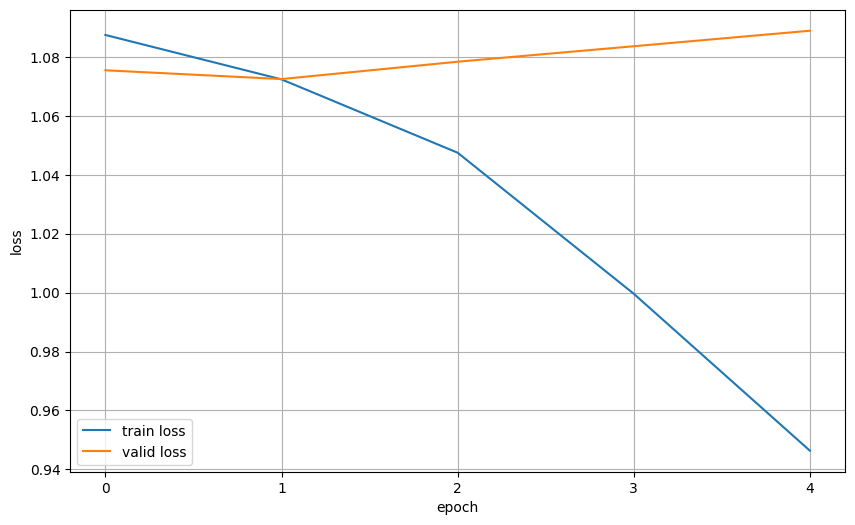

In [31]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

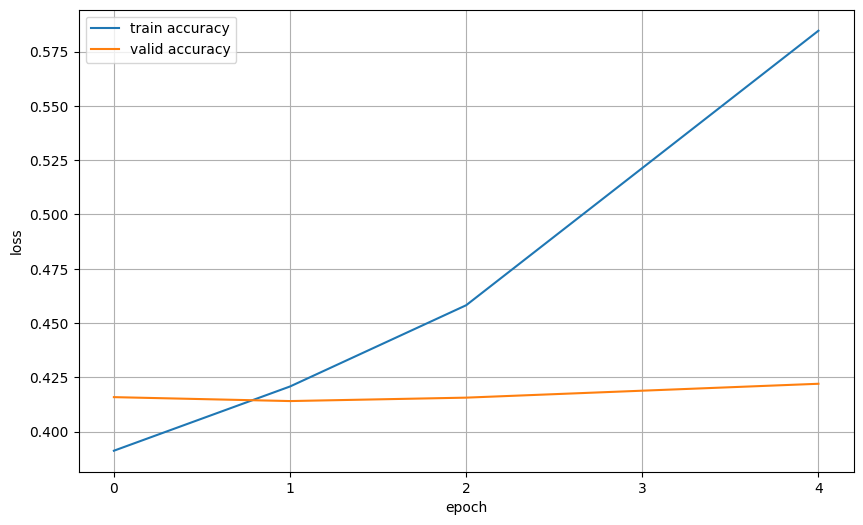

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [33]:
'''model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability'''

'model.load_state_dict(torch.load("transformer.pt"))\n\ntest_loss, test_acc = evaluate(test_data_loader, model, criterion, device)\n\nprint(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")\n\ndef predict_sentiment(text, model, tokenizer, device):\n    ids = tokenizer(text)["input_ids"]\n    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)\n    prediction = model(tensor).squeeze(dim=0)\n    probability = torch.softmax(prediction, dim=-1)\n    predicted_class = prediction.argmax(dim=-1).item()\n    predicted_probability = probability[predicted_class].item()\n    return predicted_class, predicted_probability'